# Tutorial for POPPY: Physical Optics Propagation in PYthon

This document is not intended as comprehensive documentation for the ``poppy`` package. Please see [the documentation](http://pythonhosted.org/poppy/) for full details in the API, and the SPIE papers by Perrin et al. ([2012](http://adsabs.harvard.edu/abs/2012SPIE.8442E..3DP), 2014) for further background information and discussion of algorithms.  However this notebook should be enough to get you started. 

Poppy implements an object-oriented system for modeling physical optics propagation with diffraction, particularly for telescopic and coronagraphic imaging. This tutorial covers the Fraunhofer (far-field) diffraction mode of ``poppy``, which new users should start with.  Fresnel modeling is covered in a separate tutorial.

## Getting Started

You should be able to install poppy directly from PyPI in the usual manner: 

<pre>
  pip install poppy --upgrade
  </pre>

In [73]:
import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib.ticker import FormatStrFormatter

import poppy
import astropy.units as u
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
poppy.__version__

Populating the interactive namespace from numpy and matplotlib


'0.9.2'

For all of the following examples, you will have more informative text output when running the code if you first enable Python’s logging mechanism to display log messages to screen. This can sometimes be more verbose than is desired, so feel free to turn this on or off as desired. 

In [2]:
import logging
logging.getLogger('poppy').setLevel(logging.WARN)  
#Can be logging.CRITICAL, logging.WARN, logging.INFO, logging.DEBUG for increasingly verbose output

## Working with OpticalElements

OpticalElements can be instantiated from FITS files, or created by one of a large number of analytic function definitions implemented as AnalyticOpticalElement subclasses. Typically these classes take some number of arguments to set their properties. Once instantiated, any analytic function can be displayed on screen, sampled onto a numerical grid, and/or saved to disk.:

## Working with Optical Systems and Creating PSFs

One or more OpticalElements can be arranged into an OpticalSystem, which functions in many ways like a python List, but distinguishes between pupil and image planes. OpticalSystems should start with at least one pupil plane optic, and must end with a Detector element that defines the desired sampling. 

A basic circular pupil is simple to set up and to compute the PSF for, as it should be. 

/home/gnthibault/projects/ZernikeSimulation/venv/lib/python3.8/site-packages/poppy/geometry.py:40: RuntimeWarning: divide by zero encountered in true_divide
  return 0.5 * r**2 * (np.arctan(y1/x) - np.arctan(y0/x))
/home/gnthibault/projects/ZernikeSimulation/venv/lib/python3.8/site-packages/poppy/geometry.py:40: RuntimeWarning: divide by zero encountered in true_divide
  return 0.5 * r**2 * (np.arctan(y1/x) - np.arctan(y0/x))


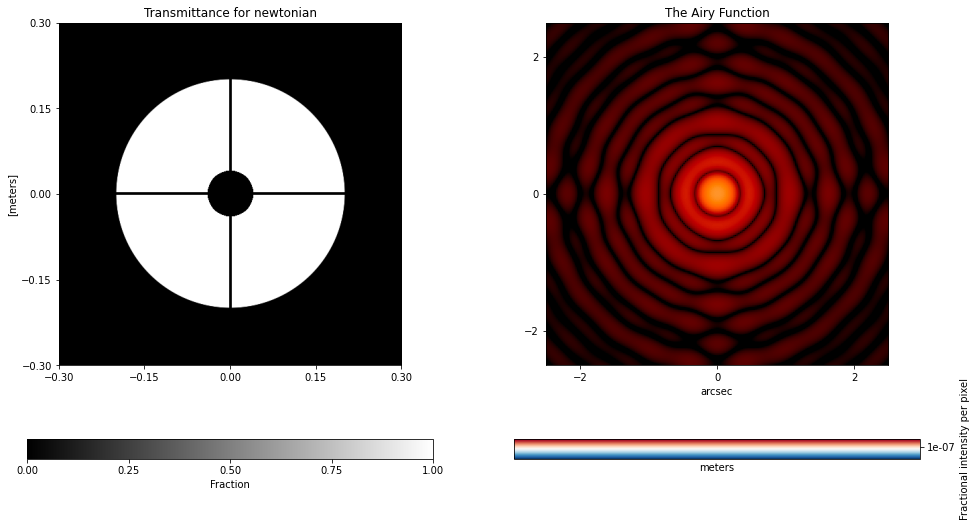

In [41]:
osys = poppy.OpticalSystem()
primary = poppy.CircularAperture(radius=200*u.mm)
secondary = poppy.SecondaryObscuration(secondary_radius=40*u.mm,
                                       n_supports=4,
                                       support_width=5*u.mm)
newtonian = poppy.CompoundAnalyticOptic(
    opticslist=[primary, secondary], name='newtonian')

osys.add_pupil(newtonian)
osys.add_detector(pixelscale=0.05, fov_arcsec=5.0)  # image plane coordinates in arcseconds

fig, ax = plt.subplots(1, 2, figsize=(16,9))
newtonian.display(what='both', ax=ax[0]);
psf = osys.calc_psf(550*u.nm, normalize="exit_pupil")
poppy.display_psf(psf, ax=ax[1], title='The Airy Function')


/home/gnthibault/projects/ZernikeSimulation/venv/lib/python3.8/site-packages/poppy/geometry.py:40: RuntimeWarning: divide by zero encountered in true_divide
  return 0.5 * r**2 * (np.arctan(y1/x) - np.arctan(y0/x))


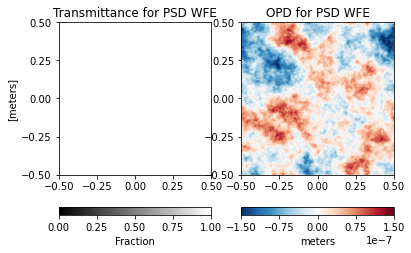

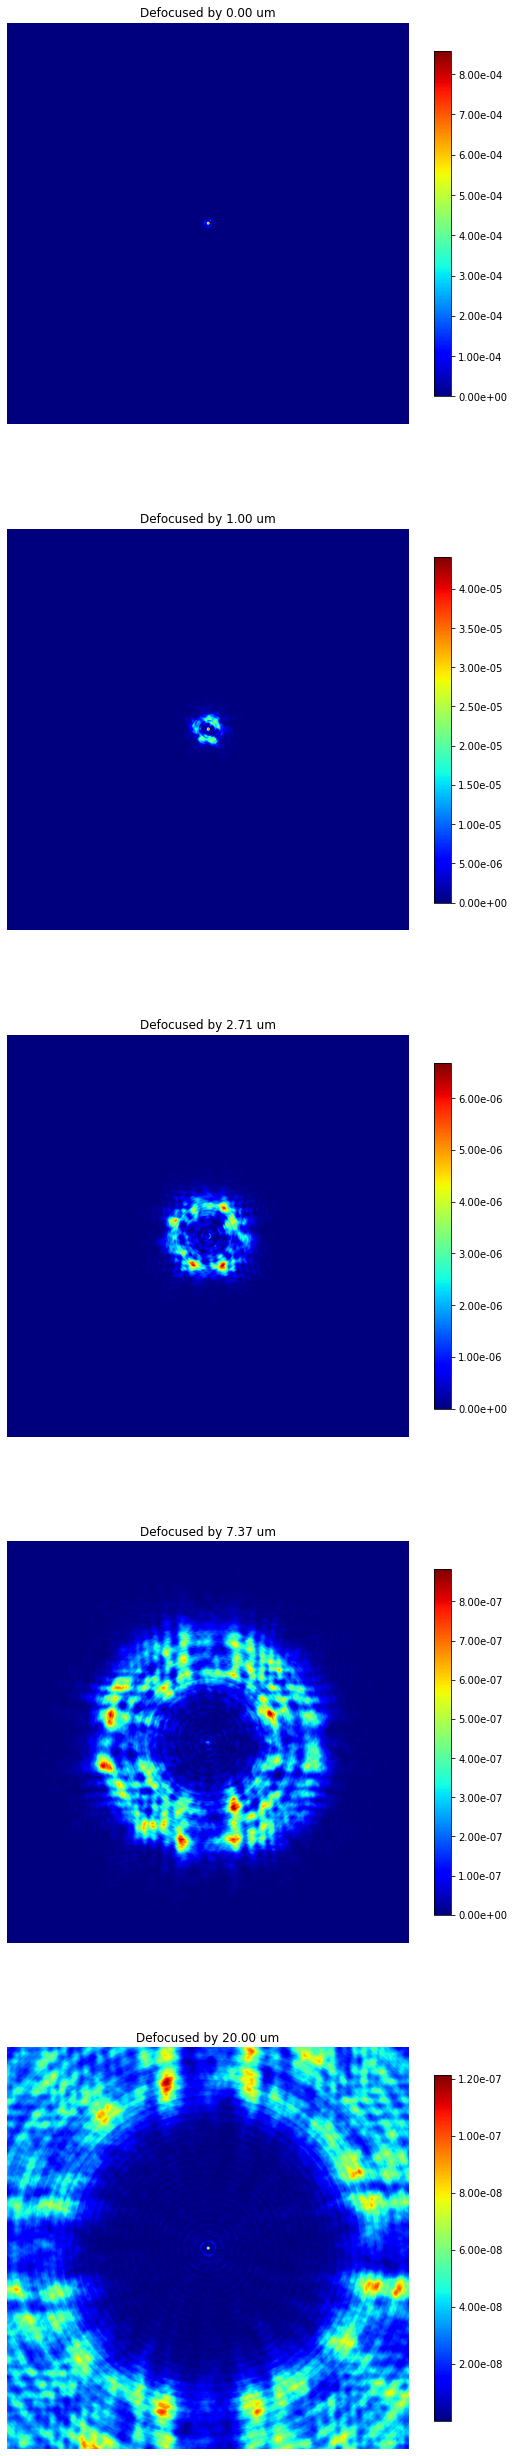

In [87]:
psfs = []
wavelen = 550*u.nm
focuses = np.logspace(0, np.log10(20), num=4, base=10)*u.um
focuses = np.insert(focuses, 0, 0)
nwaves = (focuses.to(u.nm)/wavelen.to(u.nm)).value
telescope_radius = 100*u.mm

# Simulate turbulence
turbulence = poppy.wfe.StatisticalPSDWFE(index=3.0, wfe=50*u.nm, radius=7*u.mm, seed=42)
turbulence.display(what='both', opd_vmax=150*u.nm)

fig, ax = plt.subplots(len(nwaves), 1, figsize=(9,9*len(nwaves)))

for i, nwave in enumerate(nwaves):
    osys = poppy.OpticalSystem()
    primary = poppy.CircularAperture(radius=telescope_radius)
    secondary = poppy.SecondaryObscuration(secondary_radius=40*u.mm,
                                           n_supports=4,
                                           support_width=5*u.mm)
    defocus = poppy.ThinLens(nwaves=nwave, reference_wavelength=wavelen, radius=telescope_radius)
    newtonian = poppy.CompoundAnalyticOptic(
        opticslist=[primary, secondary, defocus, turbulence], name='newtonian')

    osys.add_pupil(newtonian)
    osys.add_detector(pixelscale=0.05, fov_arcsec=100.0)  # image plane coordinates in arcseconds

    psf = osys.calc_psf(wavelength=wavelen, normalize="exit_pupil")
    psfs.append(psf)

    #poppy.display_psf(psf, ax=ax[i], title=f"Defocused by {focuses[i]:.2f}",
    #    colorbar_orientation='horizontal')
    heatmap = ax[i].imshow(psf[0].data, cmap='jet')
    ax[i].set_title(f"Defocused by {focuses[i]:.2f}")
    ax[i].axis('off')
    plt.colorbar(heatmap, ax=ax[i], format=FormatStrFormatter('%.2e'), shrink=0.82)


Note that the returned PSF is in fact a FITS HDUlist object (from ``astropy.io.fits``), suitable for saving to disk for use with standard astronomical tools. 

The FITS header contains information about the calculation that produced the PSF. 

In [88]:
psf

In [89]:
psf[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4000                                                  
NAXIS2  =                 4000                                                  
EXTEND  =                    T                                                  
PLANE1  = 'Wavefront Intensity'                                                 
WAVELEN =              5.5E-07 / Weighted mean wavelength in meters             
DIFFLMT =    0.567228217179515 / Diffraction limit lambda/D in arcsec           
OVERSAMP=                    2 / Oversampling factor for FFTs in computation    
DET_SAMP=                    2 / Oversampling factor for MFT to detector plane  
PIXELSCL=                0.025 / Scale in arcsec/pix (after oversampling)       
FOV     =                100

By combining multiple analytic optics together it is possible to create quite complex pupils:

